<a href="https://colab.research.google.com/github/columbia-data-club/meetings/blob/main/february_22_Extending_Pandas_With_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<td> <img src="https://sdzwildlifeexplorers.org/sites/default/files/2017-07/pandas-closeup.jpg" alt="Drawing" style="width: 250px;"/> </td>

## Extending Pandas with Dask

Feb 22rd, 2023

by [Roger Creel](https://rogercreel.com) for the [Columbia Data Club](https://github.com/columbia-data-club/).

This notebook underpins a ~60-75 minute presentation that demonstrates how to use Pandas with Dask.  It is geared towards complete beginners to Python and to programming. 


# **Extending Pandas with Dask**
*Presented by Columbia University Libraries*
***

Welcome to the Columbia University Library's Estending Pandas with Dask course! These are our objectives:

* Review Pandas as a tool for data analysis
* Explore how to use Dask dataframes as an extension for Pandas
* Discuss statistics and visualization capabilities of Dask + Pandas
* Answer questions! 






## **Getting started**
### *(with Google Colab)*

Topics to be covered:
1. What is Python?
2. Why does it matter?
3. How can you use Python? (IDEs, notebooks, terminal, Colab)
4. What are packages and why do we need them?
5. Basic familiarity with CoLab (shareability, power)
6. Pitfalls of using CoLab
7. Why pandas? Pandas is an open-source library that provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language.


In [ ]:
# Run these once per session, then no need to rerun them again even if kernel dies
!python -m pip install 'fastparquet'
!python -m pip install "dask[complete]"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels as sm
import requests
import pyarrow
import os
import numpy as np
import dask
import dask.dataframe as dd

We'll first download three years of data from the New York Taxi & Limousine Commission (TLC) [Trip Record Data website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

In [2]:
# Make a directory for our data if it doesn't exist
path = f'./taxi_data_parquet/'
if not os.path.isdir(path):
  os.makedirs(path)

months = [str(i).zfill(2) for i in range(1,13)]
years = ['2019', '2020']
# get the URL of one month's data from New York Suway 
for year in years:
  print(year)
  for month in months:
    print(month)
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month}.parquet"

    r = requests.get(url) # create HTTP response object
    with open(path + f"yellow_tripdata_{year}-{month}.parquet",'wb') as f:

          f.write(r.content)

# save parquet files as csv files 

# open parquet file
df = pd.read_parquet(path + 'yellow_tripdata_2020-01.parquet')
df.head()

2019
01
02


KeyboardInterrupt: ignored

We just downloaded a lot of files locally in the format TLC gave it to us: an Apache `parquet` file.  Let's check how much data we have using shell scripting command `du -sh` (disk usage, total size, human readable):

In [3]:
%%bash
cd taxi_data_parquet

du -sh

1.6G	.


How many files do we have? Let's find out using the `find` and `wc -l` (word cound by line) commands, connected via a `|` pipe: 

In [ ]:
%%bash
cd taxi_data_parquet
find . | wc -l

25


We don't want to load all those files separately.  That would be a nightmare! We want to work with them all at once.  Dask will makes that easy.  First let's get our filenames:

In [2]:
from glob import glob
filenames = sorted(glob('taxi_data_parquet/yellow_tripdata*.parquet'))
print(filenames[:3])
print(filenames[-3:])


['taxi_data_parquet/yellow_tripdata_2019-01.parquet', 'taxi_data_parquet/yellow_tripdata_2019-02.parquet', 'taxi_data_parquet/yellow_tripdata_2019-03.parquet']
['taxi_data_parquet/yellow_tripdata_2020-10.parquet', 'taxi_data_parquet/yellow_tripdata_2020-11.parquet', 'taxi_data_parquet/yellow_tripdata_2020-12.parquet']


Let's open one of them with pandas to remind ourselves what they look like.

In [3]:
df_one = pd.read_parquet(filenames[0])
df_one

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,1.0,N,151,239,1,7.00,0.50,0.5,1.65,0.00,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.60,1.0,N,239,246,1,14.00,0.50,0.5,1.00,0.00,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.00,1.0,N,236,236,1,4.50,0.50,0.5,0.00,0.00,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.00,1.0,N,193,193,2,3.50,0.50,0.5,0.00,0.00,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.00,2.0,N,193,193,2,52.00,0.00,0.5,0.00,0.00,0.3,55.55,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696612,2,2019-01-31 23:37:20,2019-02-01 00:10:43,NaN,10.24,NaN,None,142,95,0,0.00,2.75,0.0,0.00,5.76,0.3,0.00,NaN,None
7696613,2,2019-01-31 23:28:00,2019-01-31 23:50:50,NaN,12.43,NaN,None,48,213,0,48.80,5.50,0.0,0.00,0.00,0.3,54.60,NaN,None
7696614,2,2019-01-31 23:11:00,2019-01-31 23:46:00,NaN,9.14,NaN,None,159,246,0,51.05,2.75,0.5,0.00,0.00,0.3,54.60,NaN,None
7696615,2,2019-01-31 23:03:00,2019-01-31 23:14:00,NaN,0.00,NaN,None,265,265,0,0.00,0.00,0.5,9.82,0.00,0.3,0.00,NaN,None


More than seven million entries!  That's a lot, and only for one month.  If we want to look at three years of data, that would be 100+ million taxi rides.  Too many for to load into memory and do computations on.  Thankfully, Dask Dataframes is going to come to our rescue.  

In [3]:
# we'll use just the first half of 2020 because we have limited RAM
filenames_fewer = filenames[12:-9]

df = dd.read_parquet(filenames_fewer,
                     filename_suffix=".parquet",
                     engine='fastparquet',
                     parse_dates=[
                         "tpep_pickup_datetime",	"tpep_dropoff_datetime"
                         ],  
                    #  dtypes=df.dtypes.to_dict(),
                     )
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=3,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,Int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df_orig_len = len(df)
df_orig_len

15712062

What do you see? Let's look at the first rows to check they are the same.

In [6]:
### Get the first 5 rows
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,<NA>
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,<NA>
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,<NA>
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,<NA>
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,<NA>


These columns have long, hard-to-read names.  We'll want to make them shorter and drop the less useful ones.

## **Refresher on Python data structures**

But before we do that, let's review a few key data structures in python and pandas:

In [7]:
# Lists
listex = [1, 2, 3, 4, "python", "makes", "rory", "roar"]
listex[1]
listex[0:5]

# Iterable

[1, 2, 3, 4, 'python']

In [8]:
# Dictionaries
dictex = {"rory" : "the lion", "columbia": "the university", "founded": 1754}
dictex["founded"]
dictex["rory"]

# Iterable

'the lion'

Now let's clean up our data.  

In [9]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

We don't need all the columns, and the columns we do need have cumbersome names.  Let's fix that. 

In [4]:
columns = {
          'tpep_pickup_datetime':'pickup',
          'tpep_dropoff_datetime':'dropoff',
          'passenger_count':'passengers', 
          'trip_distance':'distance', 
          'payment_type':'payment_type',
          'fare_amount':'fare',
          'extra':'extra',
          'mta_tax':'tax', 
          'tip_amount':'tip', 
          'tolls_amount':'tolls', 
          'improvement_surcharge':'improvement_surcharge',
          'total_amount':'total_fare', 
          'congestion_surcharge':'congestion_tax', 
          'airport_fee':'airport_fee'
          }

# choose only columns that are keys in dictionary
df = df[list(columns.keys())]

# rename columns by values of dictionary
df = df.rename(columns=columns)

df.head()

,pickup,dropoff,passengers,distance,payment_type,fare,extra,tax,tip,tolls,improvement_surcharge,total_fare,congestion_tax,airport_fee
0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,<NA>
1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,<NA>
2,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,<NA>
3,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,<NA>
4,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,<NA>


In [11]:
# Pandas series
type(df["pickup"])

# Column

dask.dataframe.core.Series

In [12]:
df.dtypes

pickup                   datetime64[ns]
dropoff                  datetime64[ns]
passengers                      float64
distance                        float64
payment_type                      int64
fare                            float64
extra                           float64
tax                             float64
tip                             float64
tolls                           float64
improvement_surcharge           float64
total_fare                      float64
congestion_tax                  float64
airport_fee                       Int32
dtype: object

In [13]:
# Descriptions
df.describe(include = "all")

/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:2811: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  meta = data._meta_nonempty.describe(**datetime_is_numeric_kwarg)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:2811: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  meta = data._meta_nonempty.describe(**datetime_is_numeric_kwarg)


TypeError: ignored

Any ideas about why it broke?  

In [14]:
df.describe(include=['float64'])

,passengers,distance,fare,extra,tax,tip,tolls,improvement_surcharge,total_fare,congestion_tax
npartitions=1,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...


We can run this, but look at the number of tasks.  What does this mean?  

![Task graph](https://www.odatis-ocean.fr/fileadmin/_processed_/a/8/csm_Pangeo_Dask_calcul_parallele_scheduler_1ae2fe84d9.png)

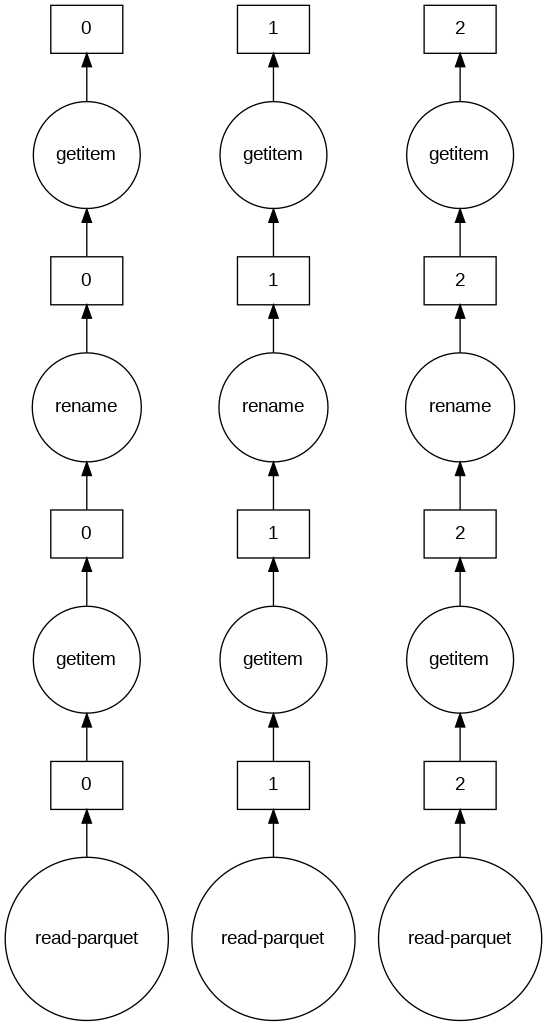

In [15]:
df.iloc[:,0].visualize()

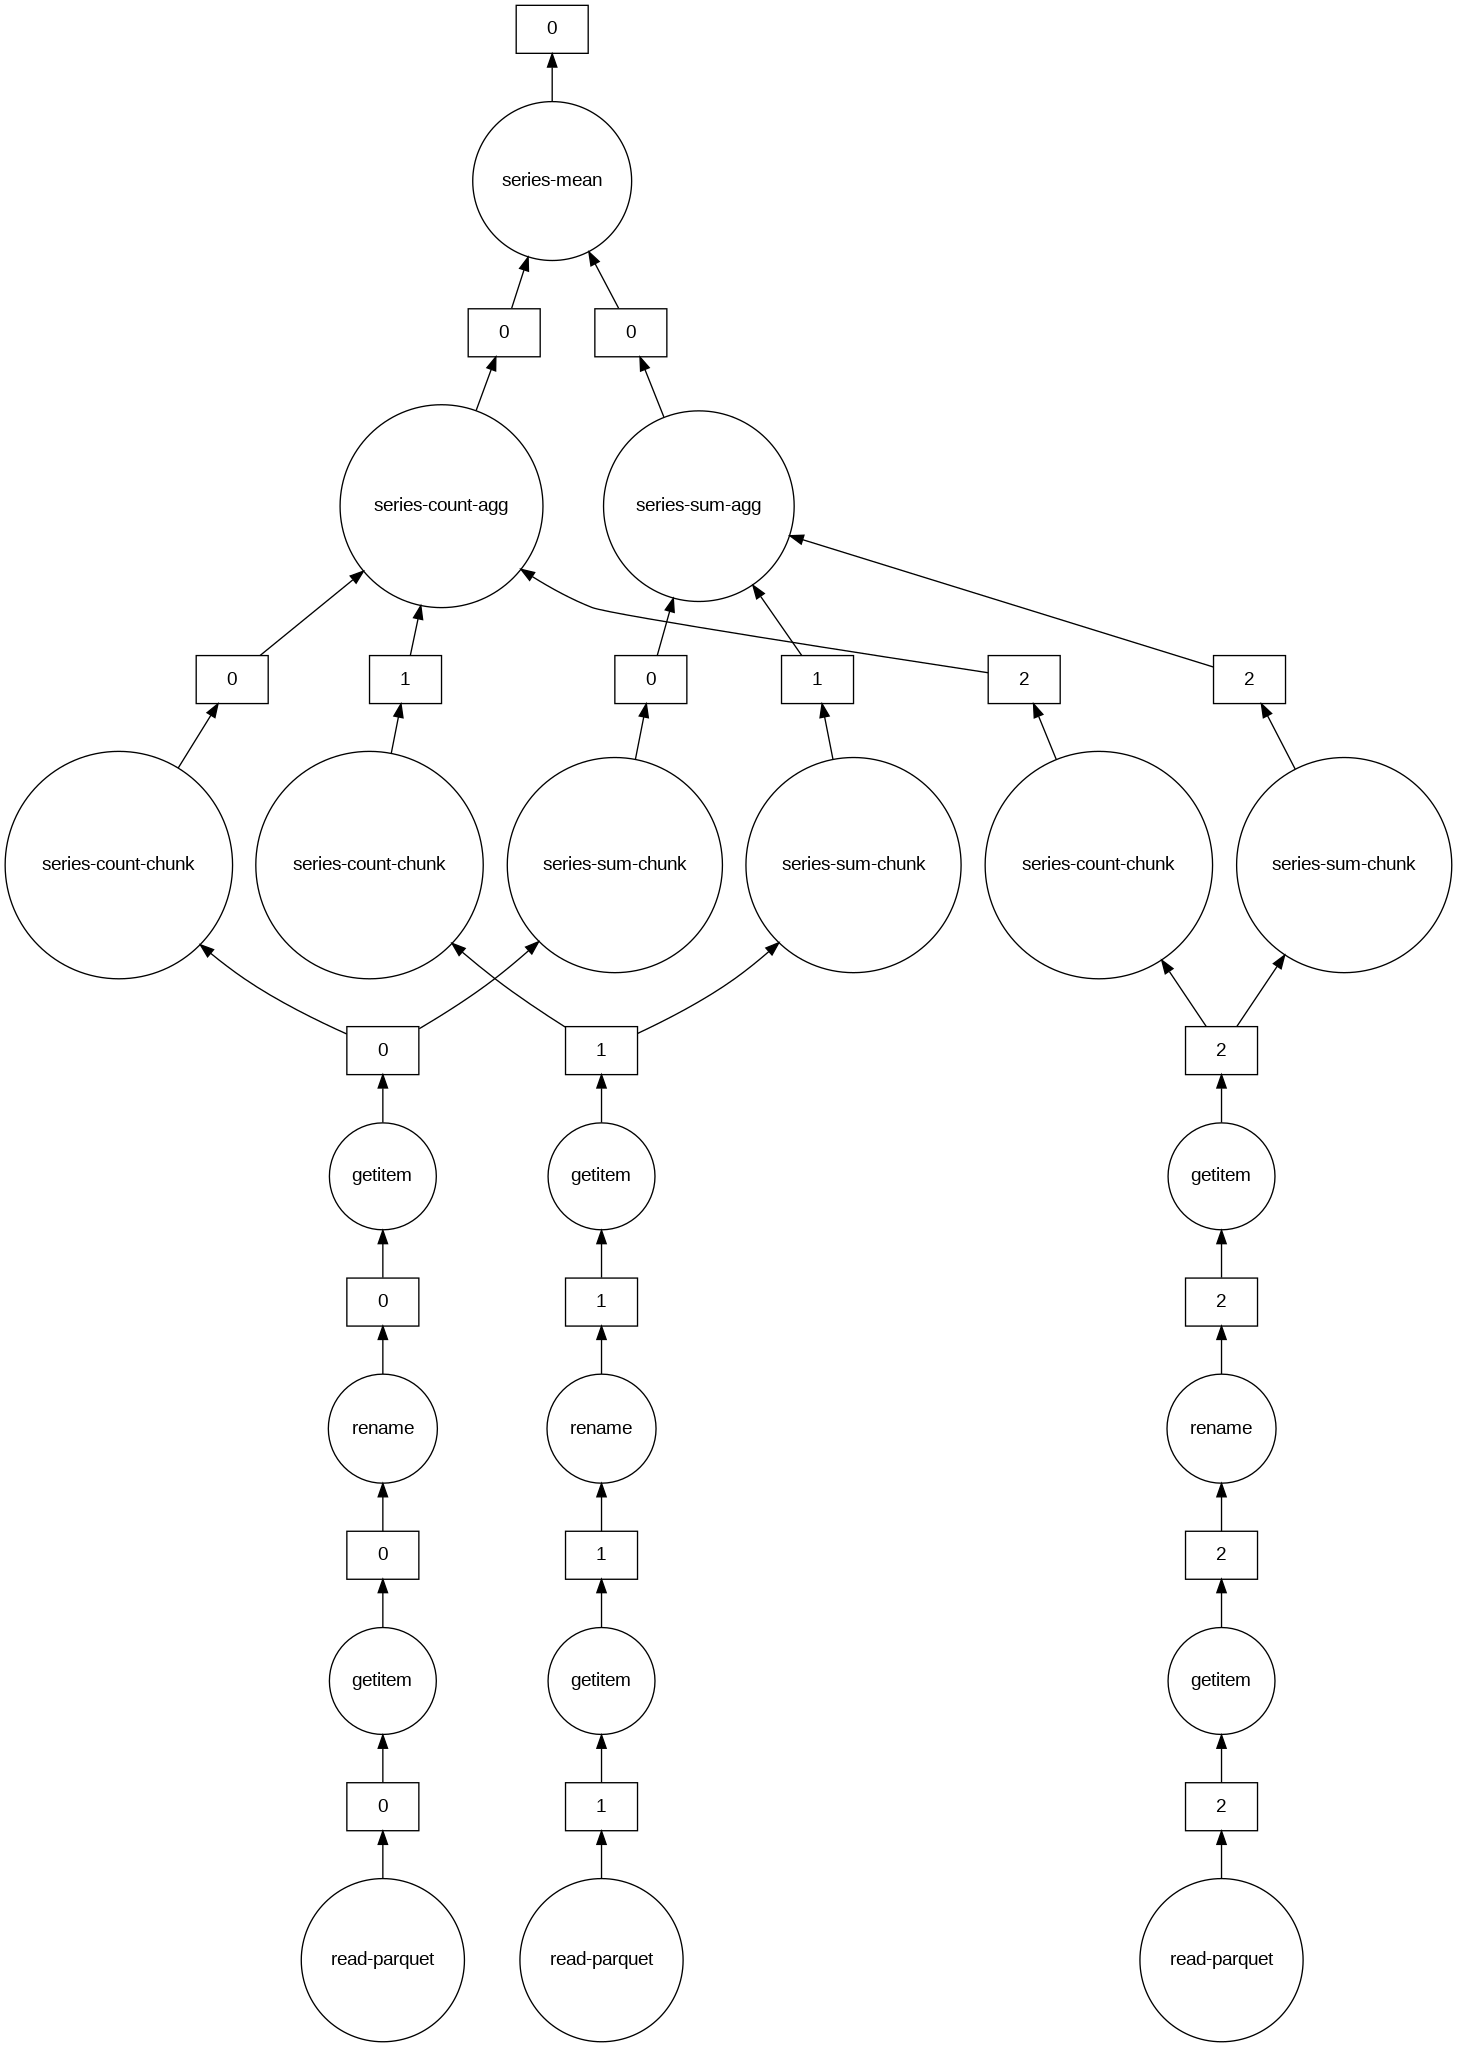

In [16]:
mean_passengers = df.passengers.mean()
mean_passengers.visualize() # .persist()
# mean_pass.compute()

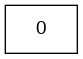

In [17]:
mean_pass_inmem = mean_passengers.persist()
mean_pass_inmem.visualize()

In [18]:
mean_pass_inmem.compute()

1.5018265127478643

Dask has some fast operations and some slower ones. Here are the fastest:

Element-wise operations: `df.x + df.y`, `df * df`

Row-wise selections: `df[df.x > 0]`

Loc: `df.loc[4.0:10.5]`

Common aggregations: `df.x.max(), df.max()`

Is in: `df[df.x.isin([1, 2, 3])]`

Date time/string accessors: `df.timestamp.month`

In [19]:
ridetime = (df.dropoff - df.pickup)
ridetime

Dask Series Structure:
npartitions=3
    timedelta64[ns]
                ...
                ...
                ...
dtype: timedelta64[ns]
Dask Name: sub, 18 tasks

The operation was fast, but running the tasks still takes time. 

In [20]:
ridetime = ridetime.loc[:10].persist()
ridetime.compute()

0    0 days 00:04:48
1    0 days 00:07:25
2    0 days 00:06:11
3    0 days 00:04:51
4    0 days 00:02:18
5    0 days 00:00:53
6    0 days 00:00:04
7    0 days 00:01:10
8    0 days 00:01:00
9    0 days 00:11:27
10   0 days 00:16:52
0    0 days 00:12:57
1    0 days 00:32:49
2    0 days 00:11:44
3    0 days 00:24:04
4    0 days 00:09:46
5    0 days 00:04:59
6    0 days 00:24:51
7    0 days 00:13:14
8    0 days 00:04:00
9    0 days 00:44:13
10   0 days 00:05:20
0    0 days 00:30:29
1    0 days 00:00:27
2    0 days 00:06:58
3    0 days 00:03:04
4    0 days 00:15:08
5    0 days 00:18:34
6    0 days 00:31:15
7    0 days 00:08:42
8    0 days 00:09:18
9    0 days 00:06:01
10   0 days 00:10:11
dtype: timedelta64[ns]

### Other fast-ish (Cleverly parallelizable) tasks:


 operations (fast):
groupby-aggregate (with common aggregations): `df.groupby(df.x).y.max()`, `df.groupby('x').min()` (see Aggregate)

groupby-apply on index: `df.groupby(['idx', 'x']).apply(myfunc)`, where idx is the index level name

value_counts: `df.x.value_counts()`

Drop duplicates: `df.x.drop_duplicates()`

Join on index: `dd.merge(df1, df2, left_index=True, right_index=True)` or `dd.merge(df1, df2, on=['idx', 'x'])` where idx is the index name for both df1 and df2

Join with pandas DataFrames: `dd.merge(df1, df2, on='id')`

Element-wise operations with different partitions / divisions: `df1.x + df2.y`

Date time resampling: `df.resample(...)`

Rolling averages: `df.rolling(...)`

Pearson’s correlation: `df[['col1', 'col2']].corr()`

In [5]:
df["pickup_day"] = df["pickup"].dt.day
df["pickup_year"] = df["pickup"].dt.year
df["pickup_month"] = df["pickup"].dt.month

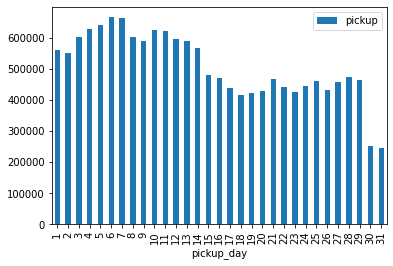

In [22]:
# Start with a simple histogram

# First with months
df_mnth_cnt = df.groupby("pickup_day")[["pickup"]].count().persist()
df_mnth_cnt.compute().plot(kind='bar')

In [23]:
df[['distance', 'fare']].corr().compute()

,distance,fare
distance,1.000000,0.002122
fare,0.002122,1.000000


Why would this correlation be so low?  

In [6]:
df = df[df['pickup_year'] > 2018]
df = df[(df['fare'] > 2.50) & (df['fare'] < 500)]
df = df[(df['distance'] > 0.05) & (df['distance'] < 500)]
df = df[df["passengers"] > 0]

Did dropping these bad values improve correlations between, for instance, distance and fare?


In [25]:
df[['distance', 'fare']].corr().compute()

,distance,fare
distance,1.000000,0.940216
fare,0.940216,1.000000


In [26]:
# df[['passengers', 'distance']].corr().compute()

Other operations are slow, however, because they require a shuffle:

Set index: `df.set_index(df.x)`

groupby-apply not on index (with anything): `df.groupby(df.x).apply(myfunc)`

Join not on the index: `dd.merge(df1, df2, on='name')`

Why is shuffling hard?  

![shuffle graphic](https://assets-global.website-files.com/63192998e5cab906c1b55f6e/633f7b5df9c63728c2ce7ac6_image-3-700x340.png)

Every output partition depends on every input partition, so the graph becomes N² in size. Even with reasonable amounts of input data, this can crash the Dask scheduler.

![crazy graph](https://assets-global.website-files.com/63192998e5cab906c1b55f6e/633f7b5df9c6372f4bce7ac3_image7.png)
The current task graph of a very small shuffle (20 partitions). It grows quadratically with the number of partitions, so imagine this times 100 or 1000—it gets large very quickly!


### Asking data-driven questions

Now that we have the data, we can ask questions with it.  For instance:

* How did average number of passengers change during the pandemic?
* Did pandemic drivers get tipped more?
* Did COVID change ride durations or distances? 

In [13]:
df_cov = df[df['pickup_month'] >= 4]
df_precov = df[df['pickup_month'] == 2]


In [14]:
df_cov['tip'].mean().compute()

1.9546808510638298

In [9]:
df_precov['tip'].mean().compute()

2.2384041761103832

In [15]:
df_cov['tip'].std().compute()

2.1158253732051557

In [11]:
df_precov['tip'].std().compute()

2.5879197354194092

In [16]:
print(len(df_precov), len(df_cov))

6035760 188


There are many other fun queestions we could ask:

- investigate the potential effects of increasing the number of people in a taxi. Does it affect how likely and how much someone is to tip? Does it relate to how far they travel?
- how much do people generally tip?
- Are there differences in volume of passengers during different times of day? 
- What about payment type - who is still using cash, and at what time of day? Are they groups?
